In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.init as init
import torch.optim as optim
from scipy.signal import savgol_filter
from collections import deque
import tqdm
import matplotlib.pyplot as plt
import random
import gymnasium as gym

%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]

num_episodes = 200
num_eval_episodes = 20
eval_interval = 10

num_repetitions = 20
num_evaluation_points = num_episodes // eval_interval
returns_over_repetitions = np.zeros((num_repetitions, num_evaluation_points))

learning_rate = 1e-3

In [3]:
# Check for GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

np.random.seed(42)
torch.manual_seed(42)

Using mps device


In [4]:
def argmax(x):
    """Own variant of np.argmax with random tie breaking"""
    try:
        return np.random.choice(np.where(x == np.max(x))[0])
    except:
        return np.argmax(x)
def smooth(y, window, poly=2):
    """
    y: vector to be smoothed
    window: size of the smoothing window"""
    # print('Smoothing with window size: {} and y: {}'.format(window, y))
    return savgol_filter(y, window, poly)


def softmax(x, temp):
    """Computes the softmax of vector x with temperature parameter 'temp'"""
    x = x / temp  # scale by temperature
    z = x - max(x)  # substract max to prevent overflow of softmax
    return np.exp(z) / np.sum(np.exp(z))  # compute softmax

class LearningCurvePlot:

    def __init__(self, title=None):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlabel("Episode")
        self.ax.set_ylabel("Episode Return")
        if title is not None:
            self.ax.set_title(title)

    def add_curve(self, x, y, label=None):
        """y: vector of average reward results
        label: string to appear as label in plot legend"""
        if label is not None:
            self.ax.plot(x, y, label=label)
        else:
            self.ax.plot(x, y)

    def set_ylim(self, lower, upper):
        self.ax.set_ylim([lower, upper])

    def add_hline(self, height, label):
        self.ax.axhline(height, ls="--", c="k", label=label)

    def save(self, name="test.png"):
        """name: string for filename of saved figure"""
        self.ax.legend()
        self.fig.savefig(name, dpi=300)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_states, num_actions):
        super(NeuralNetwork, self).__init__()

        self.dqn_model = nn.Sequential(
            nn.Linear(num_states, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_actions),
        )
        
        self.init_weights()

    def forward(self, x):
        return self.dqn_model(x)
    
    def init_weights(self):
        for layer in self.dqn_model:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)

In [6]:
class DQN_Agent:
    def __init__(self, learning_rate=1e-3):
        self.steps_done = 0
        self.learning_rate = learning_rate
        self.policy_net = NeuralNetwork(num_states=4, num_actions=2)
        self.target_net = NeuralNetwork(num_states=4, num_actions=2)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        # self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Synchronize weights of target and policy network
        self.memory = deque([], maxlen=1000000)
        self.gamma = 0.95 # Need tuning and plot graphs for different settings
        self.batch_size = 32


        
    def select_action(self, state, policy="egreedy", epsilon=0.05):
        if policy == "egreedy":
            if np.random.rand() <= epsilon:
                return torch.tensor([[env.action_space.sample()]], dtype=torch.long)
            else:
                with torch.no_grad():
                    action_values = self.policy_net(state)
                    return torch.argmax(action_values)
        elif policy == "greedy":
            with torch.no_grad():
                action_values = self.policy_net(state)
                return torch.argmax(action_values)
        # elif policy == "softmax":
        #     with torch.no_grad():
        #         action_values = self.policy_net.net(state)
        #         # Probabilities of taking each action for state s
        #         p = softmax(action_values, temp=1)
        #         action = torch.multinomial(, 1)
        #         return action

    def get_sample(self):
        return random.sample(self.memory, self.batch_size )

    def evaluate(self, max_episode_length=1000):
        returns = []
        for _ in range(num_eval_episodes):
            state= env.reset()[0]
            R_episode = 0
            for _ in range(max_episode_length):
                state = torch.from_numpy(state).float().unsqueeze(0)
                action = self.select_action(state, policy="greedy")
                next_state, reward, episode_done, episode_truncated, _= env.step(action.item())
                R_episode += reward
                if episode_done or episode_truncated:
                    break
                state = next_state
            returns.append(R_episode)
        mean_return = np.mean(returns)
        return mean_return

In [7]:
def DQN_learning():
    agent = DQN_Agent(learning_rate=learning_rate)
    reward_means = []
    for e in range(num_episodes):
        state = env.reset()[0] # Sample initial state
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        episode_done = False # Completed the episode
        episode_truncated = False # For example reaching the maximum number of steps

        while not (episode_done or episode_truncated):
            action = agent.select_action(state, policy="egreedy").reshape(1, 1) # Sample action (e.g, epsilon-greedy)
            action_index = action.item()
            next_state, reward, episode_done, episode_truncated, _ = env.step(action_index) # Simulate environment
            reward = torch.tensor([reward])
            next_state = None if episode_done else torch.tensor(next_state, dtype=torch.float32).unsqueeze(0) # If the epsidoe terminates no next state

            # Store experience in buffer
            agent.memory.append((state, action, next_state, reward))
            state = next_state

            # Sample a batch of experiences
            if len(agent.memory) >= agent.batch_size:
                experiences = agent.get_sample()
                states_tuple, actions_tuple, next_states_tuple, rewards_tuple = zip(*experiences) # Unpack the batch
                # Convert to tensors
                states_batch = torch.cat(states_tuple)
                actions_batch = torch.cat(actions_tuple)
                rewards_batch = torch.cat(rewards_tuple)

                # Calculate the current estimated Q-values by following the current policy
                current_q_values = agent.policy_net(states_batch).gather(1, actions_batch)

                # Calculate the target Q-values by Q-learning update rule
                next_state_values = torch.zeros(agent.batch_size)
                for i in range(len(next_states_tuple)):
                    if next_states_tuple[i] is not None:
                        with torch.no_grad(): # Speed up the computation by not tracking gradients
                            next_state_values[i] = agent.target_net(next_states_tuple[i]).max(1)[0]               
                target_q_values = (next_state_values * agent.gamma) + rewards_batch
                
                # Update current policy
                # criterion = torch.nn.SmoothL1Loss() # Compute Huber loss <= works better 
                criterion = torch.nn.MSELoss()
                loss = criterion(current_q_values, target_q_values.unsqueeze(1))
                agent.optimizer.zero_grad()
                loss.backward()
                # torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(), 100) # Clip gradients
                agent.optimizer.step()

                # Syncronize target and policy network to stabilize learning
                agent.steps_done += 1
                if agent.steps_done % 50 == 0:
                    agent.target_net.load_state_dict(agent.policy_net.state_dict())
        # Evaluate the performance every eval_interval episodes
        if e % eval_interval == 0:
            print("Episode: {}".format(e))
            returns = agent.evaluate()
            print(f"Evaluation: reward for episode {e} is {returns}")
            reward_means.append(returns)
            
    return reward_means

In [8]:
def average_over_repetitions():
    for i in tqdm.tqdm(range(num_repetitions)):
        returns = DQN_learning()
        returns_over_repetitions[i] = np.array(returns)

    # Plotting the average performance
    episodes = np.arange(num_evaluation_points) * eval_interval
    average_returns = np.mean(returns_over_repetitions, axis=0)

    plot = LearningCurvePlot(title="Average DQN Performance Over Repetitions")
    plot.add_curve(episodes, average_returns, label="Average Return")
    plot.save(name="dqn.png")

In [9]:

def experiment():
    average_over_repetitions()

  0%|          | 0/20 [00:00<?, ?it/s]

Episode: 0
Evaluation: reward for episode 0 is 9.25
Episode: 10
Evaluation: reward for episode 10 is 9.45
Episode: 20
Evaluation: reward for episode 20 is 10.45
Episode: 30
Evaluation: reward for episode 30 is 10.05
Episode: 40
Evaluation: reward for episode 40 is 12.5
Episode: 50
Evaluation: reward for episode 50 is 9.65
Episode: 60
Evaluation: reward for episode 60 is 14.05
Episode: 70
Evaluation: reward for episode 70 is 35.7
Episode: 80
Evaluation: reward for episode 80 is 72.6
Episode: 90
Evaluation: reward for episode 90 is 155.4
Episode: 100
Evaluation: reward for episode 100 is 134.5
Episode: 110
Evaluation: reward for episode 110 is 110.95
Episode: 120
Evaluation: reward for episode 120 is 130.2
Episode: 130
Evaluation: reward for episode 130 is 158.95
Episode: 140
Evaluation: reward for episode 140 is 173.45
Episode: 150
Evaluation: reward for episode 150 is 181.7
Episode: 160
Evaluation: reward for episode 160 is 143.6
Episode: 170
Evaluation: reward for episode 170 is 134.9

  5%|▌         | 1/20 [00:34<11:02, 34.89s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.4
Episode: 10
Evaluation: reward for episode 10 is 9.75
Episode: 20
Evaluation: reward for episode 20 is 9.35
Episode: 30
Evaluation: reward for episode 30 is 9.25
Episode: 40
Evaluation: reward for episode 40 is 15.4
Episode: 50
Evaluation: reward for episode 50 is 21.1
Episode: 60
Evaluation: reward for episode 60 is 96.8
Episode: 70
Evaluation: reward for episode 70 is 244.45
Episode: 80
Evaluation: reward for episode 80 is 253.8
Episode: 90
Evaluation: reward for episode 90 is 245.0
Episode: 100
Evaluation: reward for episode 100 is 184.8
Episode: 110
Evaluation: reward for episode 110 is 142.5
Episode: 120
Evaluation: reward for episode 120 is 147.15
Episode: 130
Evaluation: reward for episode 130 is 125.85
Episode: 140
Evaluation: reward for episode 140 is 123.25
Episode: 150
Evaluation: reward for episode 150 is 132.7
Episode: 160
Evaluation: reward for episode 160 is 187.55
Episode: 170
Evaluation: reward for episode 170 is 163.3

 10%|█         | 2/20 [01:21<12:33, 41.85s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.25
Episode: 10
Evaluation: reward for episode 10 is 9.4
Episode: 20
Evaluation: reward for episode 20 is 9.35
Episode: 30
Evaluation: reward for episode 30 is 9.6
Episode: 40
Evaluation: reward for episode 40 is 10.6
Episode: 50
Evaluation: reward for episode 50 is 13.2
Episode: 60
Evaluation: reward for episode 60 is 9.25
Episode: 70
Evaluation: reward for episode 70 is 41.75
Episode: 80
Evaluation: reward for episode 80 is 76.65
Episode: 90
Evaluation: reward for episode 90 is 102.8
Episode: 100
Evaluation: reward for episode 100 is 136.4
Episode: 110
Evaluation: reward for episode 110 is 142.55
Episode: 120
Evaluation: reward for episode 120 is 135.45
Episode: 130
Evaluation: reward for episode 130 is 132.7
Episode: 140
Evaluation: reward for episode 140 is 206.4
Episode: 150
Evaluation: reward for episode 150 is 190.8
Episode: 160
Evaluation: reward for episode 160 is 106.6
Episode: 170
Evaluation: reward for episode 170 is 217.3
Epi

 15%|█▌        | 3/20 [01:56<10:58, 38.71s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.15
Episode: 10
Evaluation: reward for episode 10 is 9.5
Episode: 20
Evaluation: reward for episode 20 is 9.55
Episode: 30
Evaluation: reward for episode 30 is 12.05
Episode: 40
Evaluation: reward for episode 40 is 11.0
Episode: 50
Evaluation: reward for episode 50 is 35.65
Episode: 60
Evaluation: reward for episode 60 is 236.35
Episode: 70
Evaluation: reward for episode 70 is 191.0
Episode: 80
Evaluation: reward for episode 80 is 225.9
Episode: 90
Evaluation: reward for episode 90 is 196.95
Episode: 100
Evaluation: reward for episode 100 is 180.5
Episode: 110
Evaluation: reward for episode 110 is 179.95
Episode: 120
Evaluation: reward for episode 120 is 127.75
Episode: 130
Evaluation: reward for episode 130 is 178.55
Episode: 140
Evaluation: reward for episode 140 is 177.25
Episode: 150
Evaluation: reward for episode 150 is 142.0
Episode: 160
Evaluation: reward for episode 160 is 118.5
Episode: 170
Evaluation: reward for episode 170 is 1

 20%|██        | 4/20 [02:43<11:13, 42.07s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.1
Episode: 10
Evaluation: reward for episode 10 is 9.5
Episode: 20
Evaluation: reward for episode 20 is 9.25
Episode: 30
Evaluation: reward for episode 30 is 9.95
Episode: 40
Evaluation: reward for episode 40 is 9.55
Episode: 50
Evaluation: reward for episode 50 is 9.85
Episode: 60
Evaluation: reward for episode 60 is 110.9
Episode: 70
Evaluation: reward for episode 70 is 137.95
Episode: 80
Evaluation: reward for episode 80 is 260.1
Episode: 90
Evaluation: reward for episode 90 is 176.35
Episode: 100
Evaluation: reward for episode 100 is 181.7
Episode: 110
Evaluation: reward for episode 110 is 170.8
Episode: 120
Evaluation: reward for episode 120 is 211.7
Episode: 130
Evaluation: reward for episode 130 is 156.7
Episode: 140
Evaluation: reward for episode 140 is 151.55
Episode: 150
Evaluation: reward for episode 150 is 157.2
Episode: 160
Evaluation: reward for episode 160 is 135.85
Episode: 170
Evaluation: reward for episode 170 is 121.95

 25%|██▌       | 5/20 [03:29<10:50, 43.37s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.4
Episode: 10
Evaluation: reward for episode 10 is 9.4
Episode: 20
Evaluation: reward for episode 20 is 9.35
Episode: 30
Evaluation: reward for episode 30 is 9.5
Episode: 40
Evaluation: reward for episode 40 is 9.55
Episode: 50
Evaluation: reward for episode 50 is 140.4
Episode: 60
Evaluation: reward for episode 60 is 213.6
Episode: 70
Evaluation: reward for episode 70 is 178.15
Episode: 80
Evaluation: reward for episode 80 is 170.45
Episode: 90
Evaluation: reward for episode 90 is 167.4
Episode: 100
Evaluation: reward for episode 100 is 218.55
Episode: 110
Evaluation: reward for episode 110 is 170.85
Episode: 120
Evaluation: reward for episode 120 is 194.2
Episode: 130
Evaluation: reward for episode 130 is 199.15
Episode: 140
Evaluation: reward for episode 140 is 182.3
Episode: 150
Evaluation: reward for episode 150 is 163.65
Episode: 160
Evaluation: reward for episode 160 is 164.7
Episode: 170
Evaluation: reward for episode 170 is 212.

 30%|███       | 6/20 [04:19<10:39, 45.71s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.35
Episode: 10
Evaluation: reward for episode 10 is 9.2
Episode: 20
Evaluation: reward for episode 20 is 9.4
Episode: 30
Evaluation: reward for episode 30 is 10.4
Episode: 40
Evaluation: reward for episode 40 is 20.15
Episode: 50
Evaluation: reward for episode 50 is 17.05
Episode: 60
Evaluation: reward for episode 60 is 33.3
Episode: 70
Evaluation: reward for episode 70 is 69.3
Episode: 80
Evaluation: reward for episode 80 is 109.6
Episode: 90
Evaluation: reward for episode 90 is 92.75
Episode: 100
Evaluation: reward for episode 100 is 149.2
Episode: 110
Evaluation: reward for episode 110 is 147.05
Episode: 120
Evaluation: reward for episode 120 is 178.3
Episode: 130
Evaluation: reward for episode 130 is 139.65
Episode: 140
Evaluation: reward for episode 140 is 129.3
Episode: 150
Evaluation: reward for episode 150 is 128.35
Episode: 160
Evaluation: reward for episode 160 is 145.1
Episode: 170
Evaluation: reward for episode 170 is 167.65


 35%|███▌      | 7/20 [04:54<09:08, 42.17s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.05
Episode: 10
Evaluation: reward for episode 10 is 9.65
Episode: 20
Evaluation: reward for episode 20 is 9.35
Episode: 30
Evaluation: reward for episode 30 is 9.25
Episode: 40
Evaluation: reward for episode 40 is 9.5
Episode: 50
Evaluation: reward for episode 50 is 12.6
Episode: 60
Evaluation: reward for episode 60 is 9.5
Episode: 70
Evaluation: reward for episode 70 is 47.7
Episode: 80
Evaluation: reward for episode 80 is 129.3
Episode: 90
Evaluation: reward for episode 90 is 157.35
Episode: 100
Evaluation: reward for episode 100 is 173.45
Episode: 110
Evaluation: reward for episode 110 is 231.0
Episode: 120
Evaluation: reward for episode 120 is 181.9
Episode: 130
Evaluation: reward for episode 130 is 142.8
Episode: 140
Evaluation: reward for episode 140 is 179.85
Episode: 150
Evaluation: reward for episode 150 is 197.5
Episode: 160
Evaluation: reward for episode 160 is 193.3
Episode: 170
Evaluation: reward for episode 170 is 157.4
Epi

 40%|████      | 8/20 [05:37<08:28, 42.40s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.3
Episode: 10
Evaluation: reward for episode 10 is 9.4
Episode: 20
Evaluation: reward for episode 20 is 9.15
Episode: 30
Evaluation: reward for episode 30 is 9.5
Episode: 40
Evaluation: reward for episode 40 is 22.35
Episode: 50
Evaluation: reward for episode 50 is 13.5
Episode: 60
Evaluation: reward for episode 60 is 75.45
Episode: 70
Evaluation: reward for episode 70 is 249.8
Episode: 80
Evaluation: reward for episode 80 is 161.35
Episode: 90
Evaluation: reward for episode 90 is 189.05
Episode: 100
Evaluation: reward for episode 100 is 146.05
Episode: 110
Evaluation: reward for episode 110 is 142.9
Episode: 120
Evaluation: reward for episode 120 is 171.25
Episode: 130
Evaluation: reward for episode 130 is 192.35
Episode: 140
Evaluation: reward for episode 140 is 144.4
Episode: 150
Evaluation: reward for episode 150 is 114.8
Episode: 160
Evaluation: reward for episode 160 is 215.65
Episode: 170
Evaluation: reward for episode 170 is 194.

 45%|████▌     | 9/20 [06:20<07:49, 42.65s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.3
Episode: 10
Evaluation: reward for episode 10 is 9.3
Episode: 20
Evaluation: reward for episode 20 is 12.85
Episode: 30
Evaluation: reward for episode 30 is 11.0
Episode: 40
Evaluation: reward for episode 40 is 11.55
Episode: 50
Evaluation: reward for episode 50 is 14.3
Episode: 60
Evaluation: reward for episode 60 is 55.6
Episode: 70
Evaluation: reward for episode 70 is 81.5
Episode: 80
Evaluation: reward for episode 80 is 217.75
Episode: 90
Evaluation: reward for episode 90 is 118.45
Episode: 100
Evaluation: reward for episode 100 is 139.2
Episode: 110
Evaluation: reward for episode 110 is 166.25
Episode: 120
Evaluation: reward for episode 120 is 300.15
Episode: 130
Evaluation: reward for episode 130 is 500.0
Episode: 140
Evaluation: reward for episode 140 is 500.0
Episode: 150
Evaluation: reward for episode 150 is 252.25
Episode: 160
Evaluation: reward for episode 160 is 240.65
Episode: 170
Evaluation: reward for episode 170 is 178.

 50%|█████     | 10/20 [07:23<08:09, 48.99s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.4
Episode: 10
Evaluation: reward for episode 10 is 9.45
Episode: 20
Evaluation: reward for episode 20 is 9.45
Episode: 30
Evaluation: reward for episode 30 is 9.25
Episode: 40
Evaluation: reward for episode 40 is 11.7
Episode: 50
Evaluation: reward for episode 50 is 130.95
Episode: 60
Evaluation: reward for episode 60 is 243.5
Episode: 70
Evaluation: reward for episode 70 is 229.65
Episode: 80
Evaluation: reward for episode 80 is 247.05
Episode: 90
Evaluation: reward for episode 90 is 257.5
Episode: 100
Evaluation: reward for episode 100 is 225.9
Episode: 110
Evaluation: reward for episode 110 is 217.3
Episode: 120
Evaluation: reward for episode 120 is 251.8
Episode: 130
Evaluation: reward for episode 130 is 193.15
Episode: 140
Evaluation: reward for episode 140 is 149.5
Episode: 150
Evaluation: reward for episode 150 is 309.6
Episode: 160
Evaluation: reward for episode 160 is 129.95
Episode: 170
Evaluation: reward for episode 170 is 162

 55%|█████▌    | 11/20 [08:20<07:40, 51.19s/it]

Episode: 0
Evaluation: reward for episode 0 is 28.0
Episode: 10
Evaluation: reward for episode 10 is 10.9
Episode: 20
Evaluation: reward for episode 20 is 21.4
Episode: 30
Evaluation: reward for episode 30 is 165.9
Episode: 40
Evaluation: reward for episode 40 is 215.1
Episode: 50
Evaluation: reward for episode 50 is 293.6
Episode: 60
Evaluation: reward for episode 60 is 244.3
Episode: 70
Evaluation: reward for episode 70 is 180.45
Episode: 80
Evaluation: reward for episode 80 is 149.8
Episode: 90
Evaluation: reward for episode 90 is 146.25
Episode: 100
Evaluation: reward for episode 100 is 191.65
Episode: 110
Evaluation: reward for episode 110 is 174.55
Episode: 120
Evaluation: reward for episode 120 is 170.65
Episode: 130
Evaluation: reward for episode 130 is 158.25
Episode: 140
Evaluation: reward for episode 140 is 235.05
Episode: 150
Evaluation: reward for episode 150 is 149.5
Episode: 160
Evaluation: reward for episode 160 is 135.15
Episode: 170
Evaluation: reward for episode 170 

 60%|██████    | 12/20 [09:12<06:53, 51.71s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.45
Episode: 10
Evaluation: reward for episode 10 is 14.7
Episode: 20
Evaluation: reward for episode 20 is 9.4
Episode: 30
Evaluation: reward for episode 30 is 16.0
Episode: 40
Evaluation: reward for episode 40 is 9.3
Episode: 50
Evaluation: reward for episode 50 is 32.1
Episode: 60
Evaluation: reward for episode 60 is 251.6
Episode: 70
Evaluation: reward for episode 70 is 185.2
Episode: 80
Evaluation: reward for episode 80 is 341.6
Episode: 90
Evaluation: reward for episode 90 is 245.35
Episode: 100
Evaluation: reward for episode 100 is 228.05
Episode: 110
Evaluation: reward for episode 110 is 187.7
Episode: 120
Evaluation: reward for episode 120 is 354.55
Episode: 130
Evaluation: reward for episode 130 is 380.7
Episode: 140
Evaluation: reward for episode 140 is 170.25
Episode: 150
Evaluation: reward for episode 150 is 132.7
Episode: 160
Evaluation: reward for episode 160 is 133.5
Episode: 170
Evaluation: reward for episode 170 is 161.4


 65%|██████▌   | 13/20 [10:13<06:19, 54.28s/it]

Episode: 0
Evaluation: reward for episode 0 is 12.25
Episode: 10
Evaluation: reward for episode 10 is 9.25
Episode: 20
Evaluation: reward for episode 20 is 9.65
Episode: 30
Evaluation: reward for episode 30 is 10.4
Episode: 40
Evaluation: reward for episode 40 is 72.15
Episode: 50
Evaluation: reward for episode 50 is 203.1
Episode: 60
Evaluation: reward for episode 60 is 497.35
Episode: 70
Evaluation: reward for episode 70 is 144.05
Episode: 80
Evaluation: reward for episode 80 is 118.1
Episode: 90
Evaluation: reward for episode 90 is 191.4
Episode: 100
Evaluation: reward for episode 100 is 500.0
Episode: 110
Evaluation: reward for episode 110 is 363.8
Episode: 120
Evaluation: reward for episode 120 is 113.6
Episode: 130
Evaluation: reward for episode 130 is 105.7
Episode: 140
Evaluation: reward for episode 140 is 163.65
Episode: 150
Evaluation: reward for episode 150 is 132.85
Episode: 160
Evaluation: reward for episode 160 is 103.4
Episode: 170
Evaluation: reward for episode 170 is 1

 70%|███████   | 14/20 [11:00<05:12, 52.06s/it]

Episode: 0
Evaluation: reward for episode 0 is 18.0
Episode: 10
Evaluation: reward for episode 10 is 10.25
Episode: 20
Evaluation: reward for episode 20 is 10.25
Episode: 30
Evaluation: reward for episode 30 is 10.0
Episode: 40
Evaluation: reward for episode 40 is 9.1
Episode: 50
Evaluation: reward for episode 50 is 15.7
Episode: 60
Evaluation: reward for episode 60 is 93.45
Episode: 70
Evaluation: reward for episode 70 is 134.4
Episode: 80
Evaluation: reward for episode 80 is 142.45
Episode: 90
Evaluation: reward for episode 90 is 137.65
Episode: 100
Evaluation: reward for episode 100 is 136.25
Episode: 110
Evaluation: reward for episode 110 is 136.55
Episode: 120
Evaluation: reward for episode 120 is 158.55
Episode: 130
Evaluation: reward for episode 130 is 116.0
Episode: 140
Evaluation: reward for episode 140 is 156.5
Episode: 150
Evaluation: reward for episode 150 is 131.1
Episode: 160
Evaluation: reward for episode 160 is 145.25
Episode: 170
Evaluation: reward for episode 170 is 1

 75%|███████▌  | 15/20 [11:38<03:59, 47.86s/it]

Episode: 0
Evaluation: reward for episode 0 is 11.0
Episode: 10
Evaluation: reward for episode 10 is 9.2
Episode: 20
Evaluation: reward for episode 20 is 10.2
Episode: 30
Evaluation: reward for episode 30 is 9.85
Episode: 40
Evaluation: reward for episode 40 is 20.45
Episode: 50
Evaluation: reward for episode 50 is 20.8
Episode: 60
Evaluation: reward for episode 60 is 183.2
Episode: 70
Evaluation: reward for episode 70 is 213.35
Episode: 80
Evaluation: reward for episode 80 is 186.7
Episode: 90
Evaluation: reward for episode 90 is 184.95
Episode: 100
Evaluation: reward for episode 100 is 169.05
Episode: 110
Evaluation: reward for episode 110 is 168.0
Episode: 120
Evaluation: reward for episode 120 is 173.95
Episode: 130
Evaluation: reward for episode 130 is 196.45
Episode: 140
Evaluation: reward for episode 140 is 130.65
Episode: 150
Evaluation: reward for episode 150 is 107.85
Episode: 160
Evaluation: reward for episode 160 is 105.3
Episode: 170
Evaluation: reward for episode 170 is 1

 80%|████████  | 16/20 [12:21<03:05, 46.40s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.0
Episode: 10
Evaluation: reward for episode 10 is 9.3
Episode: 20
Evaluation: reward for episode 20 is 9.2
Episode: 30
Evaluation: reward for episode 30 is 9.7
Episode: 40
Evaluation: reward for episode 40 is 9.85
Episode: 50
Evaluation: reward for episode 50 is 9.85
Episode: 60
Evaluation: reward for episode 60 is 20.7
Episode: 70
Evaluation: reward for episode 70 is 102.9
Episode: 80
Evaluation: reward for episode 80 is 228.5
Episode: 90
Evaluation: reward for episode 90 is 217.05
Episode: 100
Evaluation: reward for episode 100 is 206.15
Episode: 110
Evaluation: reward for episode 110 is 193.1
Episode: 120
Evaluation: reward for episode 120 is 190.25
Episode: 130
Evaluation: reward for episode 130 is 173.95
Episode: 140
Evaluation: reward for episode 140 is 148.85
Episode: 150
Evaluation: reward for episode 150 is 149.5
Episode: 160
Evaluation: reward for episode 160 is 179.75
Episode: 170
Evaluation: reward for episode 170 is 153.2
E

 85%|████████▌ | 17/20 [13:00<02:13, 44.38s/it]

Episode: 0
Evaluation: reward for episode 0 is 30.3
Episode: 10
Evaluation: reward for episode 10 is 10.75
Episode: 20
Evaluation: reward for episode 20 is 15.45
Episode: 30
Evaluation: reward for episode 30 is 12.0
Episode: 40
Evaluation: reward for episode 40 is 67.35
Episode: 50
Evaluation: reward for episode 50 is 80.15
Episode: 60
Evaluation: reward for episode 60 is 176.3
Episode: 70
Evaluation: reward for episode 70 is 120.1
Episode: 80
Evaluation: reward for episode 80 is 110.2
Episode: 90
Evaluation: reward for episode 90 is 124.25
Episode: 100
Evaluation: reward for episode 100 is 123.85
Episode: 110
Evaluation: reward for episode 110 is 344.1
Episode: 120
Evaluation: reward for episode 120 is 500.0
Episode: 130
Evaluation: reward for episode 130 is 171.55
Episode: 140
Evaluation: reward for episode 140 is 500.0
Episode: 150
Evaluation: reward for episode 150 is 109.7
Episode: 160
Evaluation: reward for episode 160 is 149.05
Episode: 170
Evaluation: reward for episode 170 is 

 90%|█████████ | 18/20 [14:03<01:39, 49.84s/it]

Episode: 0
Evaluation: reward for episode 0 is 9.45
Episode: 10
Evaluation: reward for episode 10 is 9.55
Episode: 20
Evaluation: reward for episode 20 is 9.0
Episode: 30
Evaluation: reward for episode 30 is 9.15
Episode: 40
Evaluation: reward for episode 40 is 9.05
Episode: 50
Evaluation: reward for episode 50 is 9.6
Episode: 60
Evaluation: reward for episode 60 is 10.5
Episode: 70
Evaluation: reward for episode 70 is 14.65
Episode: 80
Evaluation: reward for episode 80 is 21.2
Episode: 90
Evaluation: reward for episode 90 is 9.5
Episode: 100
Evaluation: reward for episode 100 is 9.65
Episode: 110
Evaluation: reward for episode 110 is 229.0
Episode: 120
Evaluation: reward for episode 120 is 264.15
Episode: 130
Evaluation: reward for episode 130 is 217.25
Episode: 140
Evaluation: reward for episode 140 is 286.3
Episode: 150
Evaluation: reward for episode 150 is 243.05
Episode: 160
Evaluation: reward for episode 160 is 285.2
Episode: 170
Evaluation: reward for episode 170 is 269.05
Episo

 95%|█████████▌| 19/20 [14:43<00:46, 46.82s/it]

Episode: 0
Evaluation: reward for episode 0 is 20.6
Episode: 10
Evaluation: reward for episode 10 is 11.55
Episode: 20
Evaluation: reward for episode 20 is 15.2
Episode: 30
Evaluation: reward for episode 30 is 9.4
Episode: 40
Evaluation: reward for episode 40 is 11.45
Episode: 50
Evaluation: reward for episode 50 is 138.45
Episode: 60
Evaluation: reward for episode 60 is 221.7
Episode: 70
Evaluation: reward for episode 70 is 203.3
Episode: 80
Evaluation: reward for episode 80 is 192.6
Episode: 90
Evaluation: reward for episode 90 is 212.85
Episode: 100
Evaluation: reward for episode 100 is 186.55
Episode: 110
Evaluation: reward for episode 110 is 173.2
Episode: 120
Evaluation: reward for episode 120 is 173.2
Episode: 130
Evaluation: reward for episode 130 is 137.05
Episode: 140
Evaluation: reward for episode 140 is 176.45
Episode: 150
Evaluation: reward for episode 150 is 102.1
Episode: 160
Evaluation: reward for episode 160 is 158.1
Episode: 170
Evaluation: reward for episode 170 is 1

100%|██████████| 20/20 [15:38<00:00, 46.90s/it]


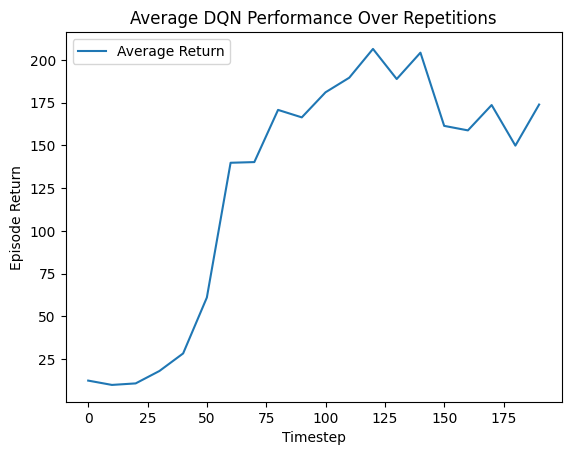

In [10]:

experiment()